In [166]:
# Imports

import matplotlib.pyplot as pyplot
import pandas as pd

import numpy as np
from numpy import unique, where

from wordcloud import WordCloud, STOPWORDS

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

import string




In [167]:
# For Stage 1 of my Animal Crossing New Horizon Review Project Results, I focused on the inital clustering
# of positive vs. negative reviews written by users. 

# The model to predict this category is trained based on the grades given
# for each review, while clustering both the review and its corresponding grade
# as a key:value pair.

# The goal for this phase was to find most frequently-occuring words that may define a positive
# vs. a negative review and prepare the dataset for further textual analysis
# if there is not enough variety between the two clusters to tell at this time.


In [168]:
# Preparing the dataset
# User review grades for Animal Crossing on the scale of 1-10

cols = ["grade", "user_name", "text"] 
ug = pd.read_csv("user_reviews.csv", usecols=[cols[0]])
us = pd.read_csv("user_reviews.csv", usecols=[cols[1]])
ut = pd.read_csv("user_reviews.csv", usecols=[cols[2]])

# Each column is converted to a list for data storage in a dictionary.
user_grades = ug.to_numpy()
user_names = us.to_numpy()
user_reviews = ut.to_numpy()

# The descriptive statistics show a mean of a relative negative grade of 4.217406, with the upper
# and lower quartile grades being on the extremes of 10 and 0 respectively.
ug.describe()

,grade
count,2999.000000
mean,4.217406
std,4.349486
min,0.000000
25%,0.000000
50%,2.000000
75%,10.000000
max,10.000000


In [169]:
# A preview of the first 10 reviews in the dataset:
pd.read_csv("user_reviews.csv", usecols=cols).head(10)

,grade,user_name,text
0,4,mds27272,My gf started playing before me. No option to ...
1,5,lolo2178,"While the game itself is great, really relaxin..."
2,0,Roachant,My wife and I were looking forward to playing ...
3,0,Houndf,We need equal values and opportunities for all...
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...
5,0,tb726,The limitation of one island per Switch (not p...
6,0,Outryder86,I was very excited for this new installment of...
7,0,Subby89,It's 2020 and for some reason Nintendo has dec...
8,0,RocketRon,This is so annoying. Only one player has the a...
9,0,chankills,I purchased this game for my household (me and...


In [170]:
# Preprocessing review data:
    # Remove stopwords
    # Remove punctuation
    # Tokenize reviews
    # Lemmatize reviews

    # This process prepares for the text data's features to be defined based on tokens
    # of a sentence, rather than having a singular shape due to the entire sentence being
    # the one and only feature detected.
    
    # Before removing stopwords, I added a few game-related words that tend to appear
    # frequently across all reviews.
for x in ["game", "play", "nintendo", "animal crossing", "new horizons"]: STOPWORDS.add(x)

    # Preprocessing:
for i in range(len(user_reviews)):
        # Remove stop words:
    list_r = user_reviews[i][0].split()
    
    for w in list_r:
        if w.lower() in STOPWORDS:
            list_r.remove(w)
    
    rm_stopwords = " ".join(list_r)
    rm_stopwords = f"{user_names[i][0]} " + rm_stopwords
    
        # Remove punctuation:
    rm_punct = rm_stopwords.translate(str.maketrans('', '', string.punctuation))
    rm_punct = rm_punct.lower()

        # Tokenization:
    tokens = word_tokenize(rm_punct)

        # Lemmatization:
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [ lemmatizer.lemmatize(token) for token in tokens ]
    str_lemmatized = " ".join(lemmatized_tokens)
    
        # Update review data:
    user_reviews[i][0] = str_lemmatized

# https://chatgpt.com/share/6754dc92-68e8-8000-b862-3c0f819b46a1

In [171]:
# Splitting the dataset into training and test data with 2-Fold cross validation.
# The split is about halfway by default: Training data is of length 1499, test data is of length 1500.

# I found that the clustering performed better with a fold of the training data
# rather than the entire training dataset, in that the clusters were more distinct
# from each other when working with one fold at a time.

# I am thinking that this is because it was easier to find patterns in a smaller portion of data, in this case
# half of the dataset, rather than in a larger group or the entire dataset.

In [172]:
from sklearn.model_selection import KFold

    # Prepare cross validation
kfold = KFold(n_splits=2, shuffle=True)

    # User grades training and test data:
user_grades_training = []
user_grades_test = []

    # Store the sets of training and test data:
for train, test in kfold.split(user_grades):
	user_grades_training.append(user_grades[train])
	user_grades_test.append(user_grades[test])

    # User reviews training and test data:
user_reviews_training = []
user_reviews_test = []

    # Store the sets of training and test data:
for train, test in kfold.split(user_reviews):
	user_reviews_training.append(user_reviews[train])
	user_reviews_test.append(user_reviews[test])


In [173]:
    # Construct splits of training data as dictionaries:

user_dict_train1 = {t[0]:g[0] for (t, g) in zip(user_reviews_training[0], user_grades_training[0])}
user_dict_train2 = {t[0]:g[0] for (t, g) in zip(user_reviews_training[1], user_grades_training[1])}

    # Another dictionary for the testing data:
user_dict_test1 = {t[0]:g[0] for (t, g) in zip(user_reviews_test[0], user_grades_test[0])}
user_dict_test2 = {t[0]:g[0] for (t, g) in zip(user_reviews_test[1], user_grades_test[1])}

# References:
# https://chatgpt.com/share/6751ee43-f1fc-8000-a087-4d6475ddc698
# https://chatgpt.com/share/674fd269-9a7c-8000-addd-cc3fe5f6c560

In [174]:
# This is the first model training for the first fold of training data.

# Sort training data into 2 clusters: 
# Positive reviews and Negative reviews

# Algorithm used: Spectral Clustering
# Code taken and modified from Lab 10 tutorial.

from sklearn.cluster import SpectralClustering

# Define dataset
X = np.array(user_grades_training[0]).reshape(-1, 1)

# Define the model
model = SpectralClustering(n_clusters=2)

# Fit model and predict clusters
yhat = model.fit_predict(X)

# Retrieve unique clusters
clusters = unique(yhat)

	# Organize clusters as a list of lists representing each cluster
user_clusters = [[] for cluster in clusters] 						
										     								 
for cluster in clusters:
		# All indices in the dataset such that the dataset element at that index is in the current cluster:
	row_ix = where(yhat == cluster)
		
		# Store these corresponding key:value pairs in the dataset dictionary into a cluster.
	for i in row_ix[0]:
		kv = list(user_dict_train1.items())[int(i)]
		user_clusters[int(cluster)].append(kv)

print("Training data cluster:")
print("Negative reviews:", user_clusters[0])
print("Positive reviews:", user_clusters[1])

Training data cluster:
Negative reviews: [('roachant wife looking forward playing it released bought it let play first made island played a bit decided play discover nintendo allows one island per switch that second player build anything island tool building considerably harder do so more one personmy wife looking forward playing game it released i bought it i let play first made island played a bit i decided play discover nintendo only allows one island per switch only that second player build anything island tool building considerably harder to do so more one person your home want to play the game you need two switch worst decision i have seen even beat eacongratulations nintendo you have officially become the worst video game company year… expand', 4), ('houndf need equal value opportunity all player the island wife the first player is great want wait progress the time i do not want her to a second class player experience i the founder fix nintendo', 0), ('professorfox beware you mu

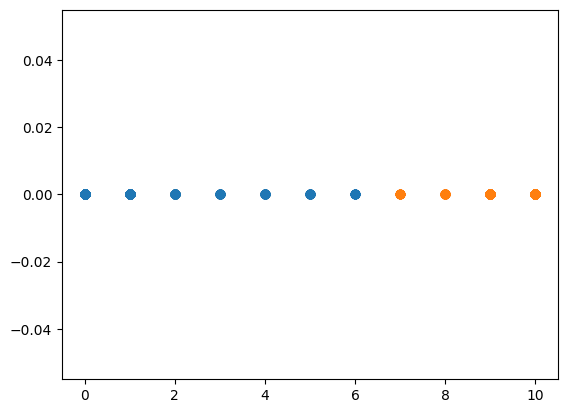

In [175]:
    # Create scatter plot of these samples:
for cluster in clusters:
	row_ix = where(yhat == cluster)
	pyplot.scatter(X[row_ix, 0], [np.zeros(len(X[row_ix, 0][0]))])

	# Show the plot:
pyplot.show()

# Blue / Grades 0-6 are negative reviews
# Orange / Grades 7-10 are positive reviews 

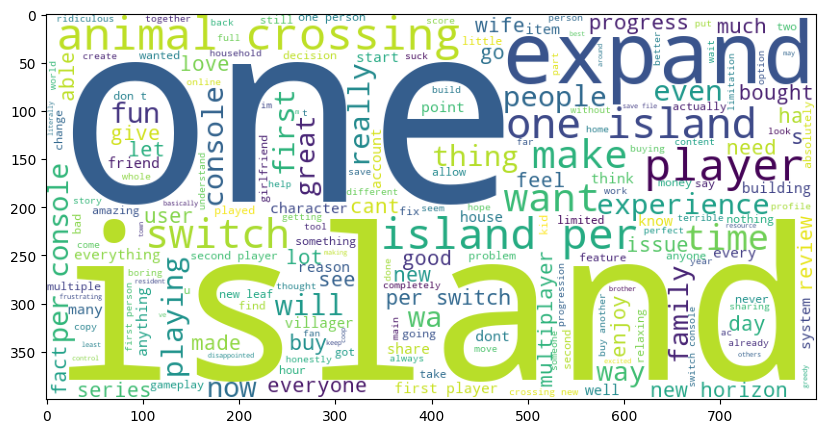

In [176]:
# Word cloud of most commonly used words for negative user reviews:
neg_user_review_text1 = " ".join(review[0] for review in user_clusters[0])

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(neg_user_review_text1)

# Display the generated word cloud
pyplot.figure(figsize=(10, 5))
pyplot.imshow(wc)
pyplot.show()

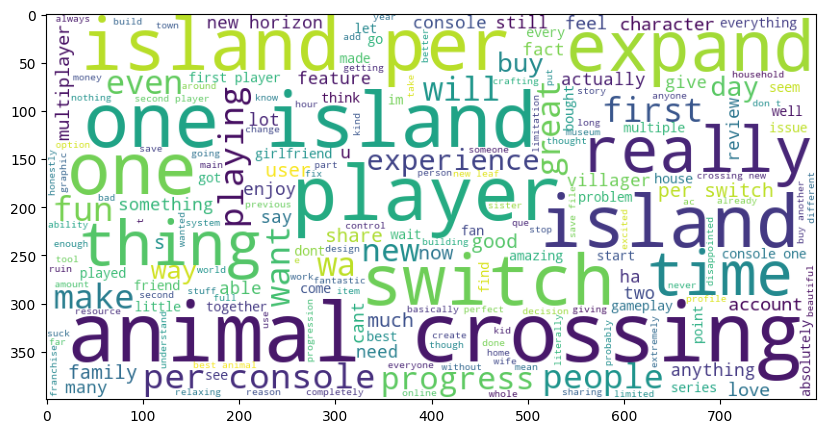

In [177]:
# Word cloud of most commonly used words for positive user reviews:
pos_user_review_text1 = " ".join(review[0] for review in user_clusters[1])

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(pos_user_review_text1)

# Display the generated word cloud
pyplot.figure(figsize=(10, 5))
pyplot.imshow(wc)
pyplot.show()

In [178]:
# The two clusters have similar most frequently occuring words that appear in the word cloud,
# but cluster 1 for the negative reviews has and extremely high frequency for "one", "island", "player", and "expand"
# whereas cluster 2 for positive reviews contains a more even distribution across the words in its word cloud.

# I think that this difference between the two clusters became more apparent in this assignment
# than in Results: Stage 1 because of the added preprocessing steps of tokenization and lemmatization,
# which generalized the data more.  This I am thinking is due to less unique features/words and all words
# being reduced to their basic forms.

In [ ]:
# The second part of this project will to be my attempt to predict a numerical value
# based on word frequency in the text data.

# This is to improve upon my Results Stage 1 by finding a way to predict conclusions of
# positivity or negativity based on the reviews text, and not the grade the review was
# paired with.

# I did this first by setting up the model to predict a grade from 0 to 10 for each
# review, and then modified the model slightly to predict either 0 (negative) or 1
# (positive) for each review.

# Random forest classifer was chosen as the model because I was inspired by its use in
#  the "spam" vs "not spam" example discussed in the book and class.

In [ ]:
# To prepare for the second round of classification, I will preprocess the text data to be
# represented entirely numerically using the TF-IDF algorithm.

# TF-IDF computes a matrix representing each review as a vector containing a number representing the frequency
# of each word in the vocabulary of all the reviews in the dataset.
# Each element in the vector represents one feature or vocabulary word.

    # Corpus of reviews that appear in the first fold of training data:
corpus = [ x for x in list(user_dict_train1.keys()) ]

    # The min_df parameter was set to ensure the vocabulary is not too limited, removing
    # words that don't appear in less than 2% of all reviews.
vectorizer = TfidfVectorizer(min_df=.02)

    # Fit the TF-IDF algorithm onto the training dataset:
vectorizer.fit(corpus)
tfidf_matrix = vectorizer.transform(corpus)

    # Features (words) of the dataset defined by TF-IDF:
vocabulary = vectorizer.get_feature_names_out()

    # Print the TF-IDF matrix:
tfidf_arr_train = tfidf_matrix.toarray()
print("TF-IDF Matrix for training data fold 1:\n")
print(tfidf_arr_train)

# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# https://chatgpt.com/c/6753e835-4c68-8000-8c6d-0f56a9446cb2
# https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

TF-IDF Matrix for training data fold 1:

[[0.         0.         0.         ... 0.1045049  0.07064133 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.29481611 0.13285631 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [181]:
print("Vocabulary of ", len(vocabulary), "unique words")
print(vocabulary)

Vocabulary of  460 unique words
['10' '1010' '2020' '60' 'ability' 'able' 'about' 'absolutely' 'ac'
 'access' 'account' 'actually' 'add' 'again' 'all' 'allow' 'allowed'
 'allows' 'almost' 'alone' 'already' 'also' 'always' 'am' 'amazing'
 'amount' 'an' 'and' 'animal' 'annoying' 'another' 'any' 'anyone'
 'anything' 'are' 'around' 'aspect' 'at' 'away' 'awesome' 'back' 'bad'
 'basically' 'be' 'beautiful' 'because' 'been' 'before' 'being' 'believe'
 'best' 'better' 'big' 'bit' 'bombing' 'boring' 'both' 'bought' 'brother'
 'bug' 'build' 'building' 'but' 'buy' 'buying' 'by' 'came' 'can' 'cant'
 'care' 'case' 'catch' 'change' 'character' 'child' 'choice' 'click'
 'cloud' 'come' 'company' 'complaining' 'complete' 'completely' 'console'
 'contains' 'content' 'control' 'coop' 'copy' 'could' 'craft' 'crafting'
 'create' 'crossing' 'cute' 'day' 'de' 'deal' 'decision' 'definitely'
 'design' 'dialogue' 'didnt' 'different' 'disappointed' 'disappointing'
 'diy' 'do' 'doe' 'doesnt' 'don' 'done' 'dont' '

In [182]:
# Train the random forest on the first fold of training data:

    # Each review represented as TF-IDF features will be the x-values for training.
    # The grades for each review will be the y-values predicted for each x-value in testing.
all_grades = list(user_dict_train1.values())
clf = RandomForestClassifier(max_depth=70)

    # Train the random forest:
clf.fit(tfidf_arr_train, all_grades)

    # Predicting on the training data:
train_predict = clf.predict(tfidf_arr_train)

In [183]:
# Comparing the training data and prediction based on the training data:

    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:
for x in range(0,11):
    print(f"Grade {x} appears {list(user_dict_train1.values()).count(x)} times in training.")
    print(f"Grade {x} appears {list(train_predict).count(x)} times in prediction")
    print()
    
# More or less, the frequency of grades predicted are very accurate and close
# to the training data. 
# Grade 0 is predicted slightly more than it appears in the training data.
# Grade 10 is predicted very slightly less than it appears in the training data.

Grade 0 appears 577 times in training.
Grade 0 appears 585 times in prediction

Grade 1 appears 135 times in training.
Grade 1 appears 134 times in prediction

Grade 2 appears 78 times in training.
Grade 2 appears 76 times in prediction

Grade 3 appears 43 times in training.
Grade 3 appears 43 times in prediction

Grade 4 appears 49 times in training.
Grade 4 appears 48 times in prediction

Grade 5 appears 40 times in training.
Grade 5 appears 39 times in prediction

Grade 6 appears 18 times in training.
Grade 6 appears 18 times in prediction

Grade 7 appears 15 times in training.
Grade 7 appears 15 times in prediction

Grade 8 appears 44 times in training.
Grade 8 appears 44 times in prediction

Grade 9 appears 134 times in training.
Grade 9 appears 134 times in prediction

Grade 10 appears 366 times in training.
Grade 10 appears 363 times in prediction



Text(0.5, 1.0, 'Predicting grades for train reviews:')

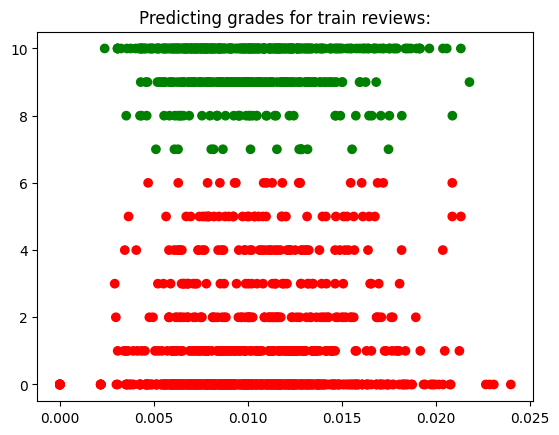

In [184]:
# Plot the training data predictions:

colors = ['red' if val < 7 else 'green' for val in list(train_predict)]

pyplot.scatter( x = [ np.mean(x) for x in tfidf_arr_train ], y= list(train_predict), c=colors)
pyplot.title("Predicting grades for train reviews:")

# The x-value chosen to represent each data point were not chosen to mean much; it is only the mean number of 
# all the values in the TF-IDF vector for each review. I chose it to separate each point from each other for
# the sake of visualization

# However, this can provide some insight in that values with lower means likely means their textual contents
# likely did not contain as much of the vocabulary defined by TF-IDF.

# The values towards the higher end of the x-axis might hold a more of words in the vocabulary.

# The values in the middle of the x-axis may hold a more specified frequency of most-commonly appearing words
# and could be keys to finding which words define a positive or negative review.

# The color red is to represent the negative review cluster of grades below 7 as found with
# spectral clustering earlier, and the color green represents the positive review cluster of
# reviews that contain grade 7 and higher.

In [185]:
# TF-IDF matrix for the test data

corpus_test = [ x for x in list(user_dict_test1.keys()) ]

    # Print the TF-IDF matrix:
tfidf_matrix_test = vectorizer.transform(corpus_test)
tfidf_arr_test = tfidf_matrix_test.toarray()

print("TF-IDF array for test data fold 1:\n")
print(tfidf_arr_test)

TF-IDF array for test data fold 1:

[[0.         0.         0.         ... 0.         0.15839893 0.        ]
 [0.         0.         0.         ... 0.10694188 0.         0.        ]
 [0.         0.         0.         ... 0.         0.14219332 0.        ]
 ...
 [0.         0.         0.4369744  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.23149476 0.         0.        ]]


In [186]:
# Predict grades for the reviews in the test data with random forest classifer:
test_predict = clf.predict(tfidf_arr_test)

    # Print how many times each grade shows up in the original testing data
    # and how many times each grade shows up in the test prediction data:
for x in range(0,11):
    print(f"Grade {x} appears {list(user_dict_test1.values()).count(x)} times in test data.")
    print(f"Grade {x} appears {list(test_predict).count(x)} times in prediction.")
    print()
    
# The same prediction trend with grades 0 and 10 as found in the training data appeared
# again for the test data, on a much larger scale.

# Grade 0 was predicted to appear about half as much more than it does in the test data.
# Grade 10 doesn't perform as badly and is predicted about 100 less times than it actually appears in the test data.
# The model did not perform well in predicting values 1-9, for some of these not predicting any occurences at all.

# I tried running the model with more trees (up to 300), but it didn't improve much.
# The model performed worse with less trees (about 10 to 50).

Grade 0 appears 581 times in test data.
Grade 0 appears 1282 times in prediction.

Grade 1 appears 120 times in test data.
Grade 1 appears 9 times in prediction.

Grade 2 appears 53 times in test data.
Grade 2 appears 1 times in prediction.

Grade 3 appears 55 times in test data.
Grade 3 appears 2 times in prediction.

Grade 4 appears 56 times in test data.
Grade 4 appears 1 times in prediction.

Grade 5 appears 38 times in test data.
Grade 5 appears 0 times in prediction.

Grade 6 appears 26 times in test data.
Grade 6 appears 0 times in prediction.

Grade 7 appears 19 times in test data.
Grade 7 appears 0 times in prediction.

Grade 8 appears 47 times in test data.
Grade 8 appears 2 times in prediction.

Grade 9 appears 119 times in test data.
Grade 9 appears 2 times in prediction.

Grade 10 appears 386 times in test data.
Grade 10 appears 201 times in prediction.



Text(0.5, 1.0, 'Predicting grades for test reviews:')

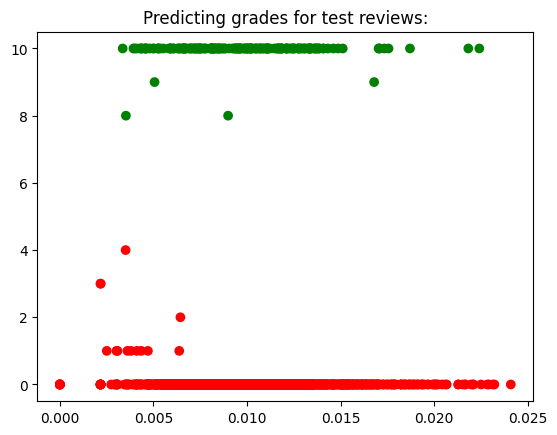

In [187]:
# Plot the test predictions:

colors = ['red' if val < 7 else 'green' for val in list(test_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_test], y=list(test_predict), c=colors)
pyplot.title("Predicting grades for test reviews:")

Text(0.5, 1.0, 'User Grades for Animal Crossing: New Horizons')

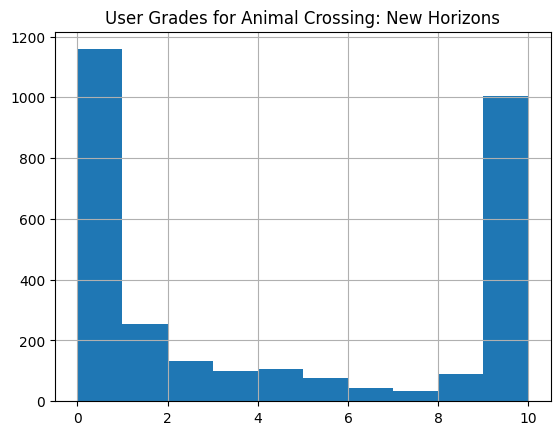

In [188]:
# The classification with random forest is probably meant for something more discrete, or to work with predicting a smaller number of categories.

# Below will be the classifier run again, but every grade in the y-value data to predict is mapped to 0 (negative review) or 1 (positive review).

# I am expecting that the classifer will perform a little more accurately with only 2 groups to distinguish rather than 10.
# In the original training data, it appears that more extreme grades of 0 and 10 were most common.
# The grades in between did not even appear half as much as these two grades did, so due to this imbalance it makes sense the
# forest classifier would perform badly for predicting these values.

ug.hist()
pyplot.title("User Grades for Animal Crossing: New Horizons")

In [189]:
# Training the model on the training data for the first fold and corresponding binary y-values:
    
    # One-hot encoded y-value data:
all_grades = [0 if x < 7 else 1 for x in list(user_dict_train1.values())]
clf = RandomForestClassifier(max_depth=70)

    # Training the model:
clf.fit(tfidf_arr_train, all_grades)
train_predict = clf.predict(tfidf_arr_train)

In [190]:
# Comparing the training data and prediction based on the training data:

negative_train = [i for i in list(user_dict_train1.values()) if i < 7 ]
positive_train = [i for i in list(user_dict_train1.values()) if i > 7 ]

negative_predict_tr = [i for i in train_predict if i < 1 ]
positive_predict_tr = [i for i in train_predict if i > 0 ]


    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:

print(f"Negative reviews appear {len(negative_train)} times in train data.")
print(f"Positive reviews appear {len(positive_train)} times in train data.")
print()
print(f"Negative reviews appear {len(negative_predict_tr)} times in prediction.")
print(f"Positive reviews appear {len(positive_predict_tr)} times in prediction.")
    

# More or less, the frequency of grades predicted are very accurate and close
# to the training data.

Negative reviews appear 940 times in train data.
Positive reviews appear 544 times in train data.

Negative reviews appear 947 times in prediction.
Positive reviews appear 552 times in prediction.


Text(0.5, 1.0, 'Predicting train reviews as negative or positive:')

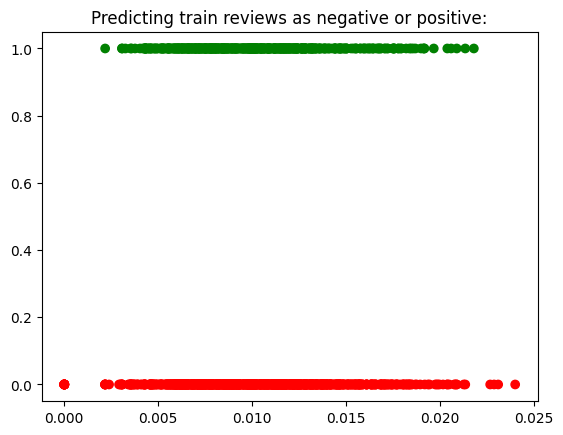

In [191]:
# Plot the new train predictions:

colors = ['red' if val < 1 else 'green' for val in list(train_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_train], y=list(train_predict), c=colors)
pyplot.title("Predicting train reviews as negative or positive:")

In [ ]:
# Predict based on test data:
test_predict = clf.predict(tfidf_arr_test)

# Comparing the training data and prediction based on the training data:

negative_test = [i for i in list(user_dict_test1.values()) if i < 7 ]
positive_test = [i for i in list(user_dict_test1.values()) if i > 7 ]

negative_predict_te = [i for i in test_predict if i < 1 ]
positive_predict_te = [i for i in test_predict if i > 0 ]


    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:

print(f"Negative reviews appear {len(negative_test)} times in test data.")
print(f"Positive reviews appear {len(positive_test)} times in test data.")
print()
print(f"Negative reviews appear {len(negative_predict_te)} times in prediction.")
print(f"Positive reviews appear {len(positive_predict_te)} times in prediction.")
    

# When categorized purely as positive or negative, the testing data performs alright, but there is quite
# a skew twoards the negative reviews than the positive reviews as comapred with the original testing data.

# The positive reviews predicted have about a loss of 200 reviews, whereas the negative reviews predicted
# gained about 200 reviews.

Negative reviews appear 929 times in test data.
Positive reviews appear 552 times in test data.

Negative reviews appear 1263 times in prediction.
Positive reviews appear 237 times in prediction.


Text(0.5, 1.0, 'Predicting test reviews as negative or positive:')

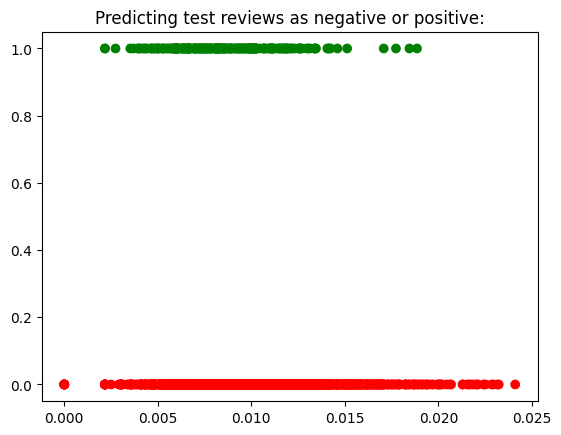

In [194]:
# Plot the test predictions:

colors = ['red' if val < 1 else 'green' for val in list(test_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_test], y=list(test_predict), c=colors)
pyplot.title("Predicting test reviews as negative or positive:")

In [ ]:
# I was initially planning to do a histogram or some other type of graph
# to represent the frequency of words in the positive or negative clusters.

# This was the step to confirm if positive or negative reviews could be defined
# by the frequency of certain words.

# However, I have run out of time! ;n;

# When reading reviews on my own, it does seem that many users complain about the
# fact that players can only have one island for their characters per Nintendo switch console.

# The word clouds seem to confirm that negative reviews feature words reffering
# to this complaint.

# However, even many of the positive reviews, including those that gave the game
# full marks, also address this issue as something they did not like about it
# even if they liked all of its other gameplay features.

# The word clouds seem to confirm that users talk about more things about Animal Crossing
# and not focus as much on the one island per Switch feature that the negative
# reviews zoom in on.

In [ ]:
# The next part of the project will be to perform all of this again on 
# the second fold of data to confirm if the pattern is similar.


In [198]:
# This is the first model training for the second fold of training data.

# Sort training data into 2 clusters: 
# Positive reviews and Negative reviews

# Algorithm used: Spectral Clustering
# Code taken and modified from Lab 10 tutorial.

# Define dataset
X = np.array(user_grades_training[1]).reshape(-1, 1)

# Define the model
model = SpectralClustering(n_clusters=2)

# Fit model and predict clusters
yhat = model.fit_predict(X)

# Retrieve unique clusters
clusters = unique(yhat)

	# Organize clusters as a list of lists representing each cluster
user_clusters = [[] for cluster in clusters] 						
										     								 
for cluster in clusters:
		# All indices in the dataset such that the dataset element at that index is in the current cluster:
	row_ix = where(yhat == cluster)
		
		# Store these corresponding key:value pairs in the dataset dictionary into a cluster.
	for i in row_ix[0]:
		kv = list(user_dict_train2.items())[int(i)]
		user_clusters[int(cluster)].append(kv)

print("Training data cluster:")
print("Negative reviews:", user_clusters[0])
print("Positive reviews:", user_clusters[1])

Training data cluster:
Negative reviews: [('mds27272 gf started playing me option create own island guy 2nd player start console suck miss on much only 1st player get term activity resource etc absolutely terrible have buy a 2nd console more one person your household want get the full experience unacceptable', 5), ('lolo2178 great really relaxing gorgeous cant ignore one thing ruin whole experience me a lot people seen different user reviewsthat thing only 1 island per console decision limit one person able enjoy full experience also nuke creative control island havewhile game itself great really relaxing gorgeous cant ignore one thing that ruin the whole experience me a lot other people seen the different user reviewsthat thing is that you only 1 island per console decision limit one person able enjoy the full experience also nuke creative control the island you the other usershouse furniture hope can soon fix big issue for now killed intention had play the game… expand', 0), ('tb726 

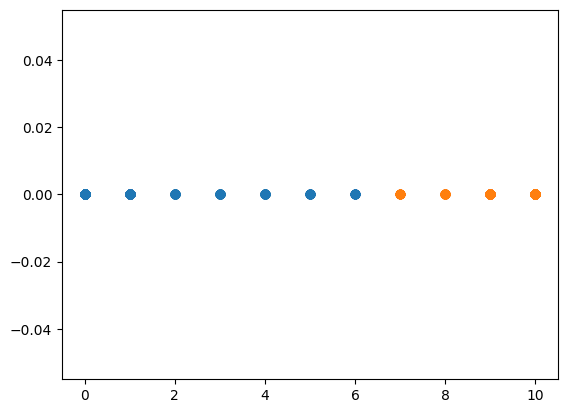

In [199]:
    # Create scatter plot of these samples:
for cluster in clusters:
	row_ix = where(yhat == cluster)
	pyplot.scatter(X[row_ix, 0], [np.zeros(len(X[row_ix, 0][0]))])

	# Show the plot:
pyplot.show()

# Blue / Grades 0-6 are negative reviews
# Orange / Grades 7-10 are positive reviews 

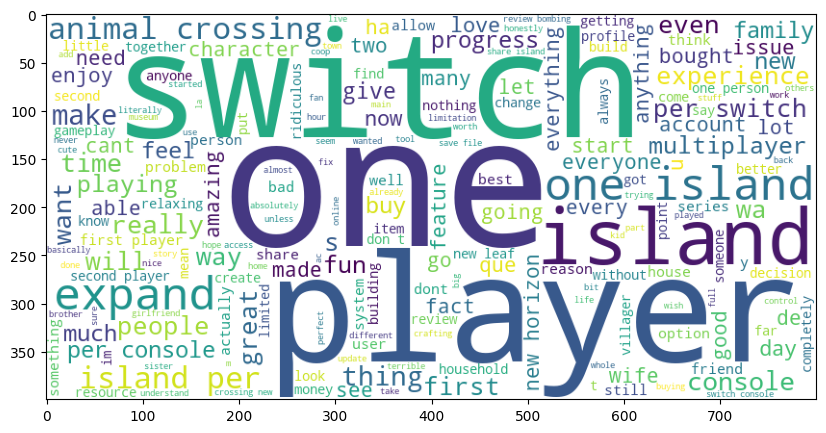

In [200]:
# Word cloud of most commonly used words for negative user reviews:
neg_user_review_text1 = " ".join(review[0] for review in user_clusters[0])

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(neg_user_review_text1)

# Display the generated word cloud
pyplot.figure(figsize=(10, 5))
pyplot.imshow(wc)
pyplot.show()

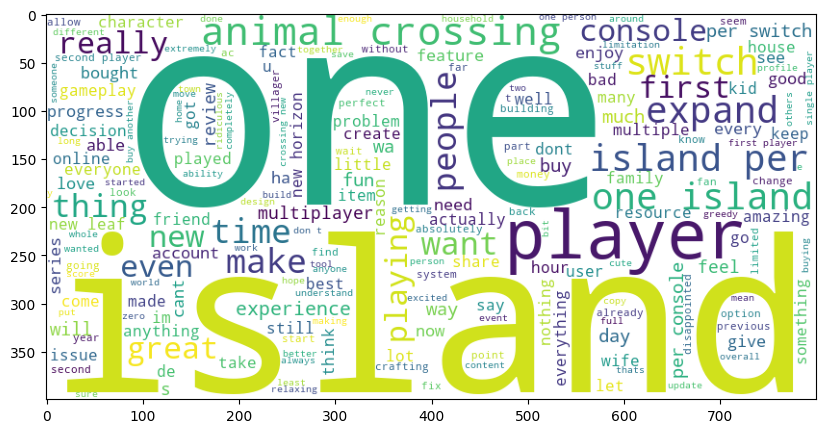

In [201]:
# Word cloud of most commonly used words for positive user reviews:
pos_user_review_text1 = " ".join(review[0] for review in user_clusters[1])

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(pos_user_review_text1)

# Display the generated word cloud
pyplot.figure(figsize=(10, 5))
pyplot.imshow(wc)
pyplot.show()

In [ ]:
# For this second fold, both negative and positive review clusters
# feature the words "one" and "island" as the two most frequently occuring words.

# The negative cluster also contains higher frequencies for the word "switch".

# For both clusters, these words take up most of the space in the word cloud.

# This pattern contrasts with the clusters in the first fold, where the positive cluster
# contains a more balanced number of frequencies for each word.


In [202]:
# To prepare for the second round of classification, I will preprocess the text data to be
# represented entirely numerically using the TF-IDF algorithm.

# TF-IDF computes a matrix representing each review as a vector containing a number representing the frequency
# of each word in the vocabulary of all the reviews in the dataset.
# Each element in the vector represents one feature or vocabulary word.

    # Corpus of reviews that appear in the first fold of training data:
corpus = [ x for x in list(user_dict_train2.keys()) ]

    # The min_df parameter was set to ensure the vocabulary is not too limited, removing
    # words that don't appear within 2% of all reviews.
vectorizer = TfidfVectorizer(min_df=.02)

    # Fit the TF-IDF algorithm onto the training dataset:
vectorizer.fit(corpus)
tfidf_matrix = vectorizer.transform(corpus)

    # Features (words) of the dataset defined by TF-IDF:
vocabulary = vectorizer.get_feature_names_out()

    # Print the TF-IDF matrix:
tfidf_arr_train = tfidf_matrix.toarray()
print("TF-IDF Matrix for training data fold 2:\n")
print(tfidf_arr_train)

# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# https://chatgpt.com/c/6753e835-4c68-8000-8c6d-0f56a9446cb2
# https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

TF-IDF Matrix for training data fold 2:

[[0.         0.         0.         ... 0.16135353 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.14459161 0.         0.        ]
 ...
 [0.         0.         0.29933802 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
print("Vocabulary of ", len(vocabulary), "unique words")
print(vocabulary)

# The number of features are slightly less for this fold, but more or less
# the same.

Vocabulary of  449 unique words
['10' '1010' '2020' '60' 'ability' 'able' 'about' 'absolutely' 'ac'
 'access' 'account' 'actually' 'add' 'addition' 'again' 'all' 'allow'
 'allowed' 'allows' 'almost' 'alone' 'already' 'also' 'always' 'am'
 'amazing' 'an' 'and' 'animal' 'annoying' 'another' 'any' 'anyone'
 'anything' 'are' 'around' 'aspect' 'at' 'away' 'back' 'bad' 'basically'
 'be' 'beautiful' 'because' 'been' 'before' 'behind' 'being' 'best'
 'better' 'big' 'bit' 'bombing' 'boring' 'bought' 'break' 'brother' 'bug'
 'build' 'building' 'but' 'buy' 'buying' 'by' 'came' 'can' 'cant' 'change'
 'character' 'child' 'choice' 'click' 'come' 'company' 'complete'
 'completely' 'console' 'contains' 'content' 'contribute' 'control' 'coop'
 'copy' 'could' 'craft' 'crafting' 'create' 'created' 'crossing' 'cute'
 'day' 'de' 'decided' 'decision' 'definitely' 'design' 'designed' 'did'
 'different' 'disappointed' 'disappointing' 'do' 'doe' 'doesnt' 'don'
 'done' 'dont' 'due' 'each' 'easily' 'either' 'el'

In [ ]:
# Train the random forest on the second fold of training data:

    # Each review represented as TF-IDF features will be the x-values for training.
    # The grades for each review will be the y-values predicted for each x-value in testing.
all_grades = list(user_dict_train2.values())
clf = RandomForestClassifier(max_depth=70)

    # Train the random forest:
clf.fit(tfidf_arr_train, all_grades)

    # Predicting on the training data:
train_predict = clf.predict(tfidf_arr_train)

In [ ]:
# Comparing the training data and prediction based on the training data:

    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:
for x in range(0,11):
    print(f"Grade {x} appears {list(user_dict_train2.values()).count(x)} times in training.")
    print(f"Grade {x} appears {list(train_predict).count(x)} times in prediction.")
    print()
    
# More or less, the frequency of grades predicted are very accurate and close
# to the training data. 

# The same trend with grades 0 and 10 appear for this second fold of data:

# Grade 0 is predicted slightly more than it appears in the training data.
# Grade 10 is predicted very slightly less than it appears in the training data.

Grade 0 appears 581 times in training.
Grade 0 appears 590 times in prediction

Grade 1 appears 120 times in training.
Grade 1 appears 118 times in prediction

Grade 2 appears 53 times in training.
Grade 2 appears 53 times in prediction

Grade 3 appears 55 times in training.
Grade 3 appears 55 times in prediction

Grade 4 appears 56 times in training.
Grade 4 appears 56 times in prediction

Grade 5 appears 38 times in training.
Grade 5 appears 38 times in prediction

Grade 6 appears 26 times in training.
Grade 6 appears 25 times in prediction

Grade 7 appears 19 times in training.
Grade 7 appears 19 times in prediction

Grade 8 appears 47 times in training.
Grade 8 appears 47 times in prediction

Grade 9 appears 119 times in training.
Grade 9 appears 117 times in prediction

Grade 10 appears 386 times in training.
Grade 10 appears 382 times in prediction



Text(0.5, 1.0, 'Predicting grades for train reviews:')

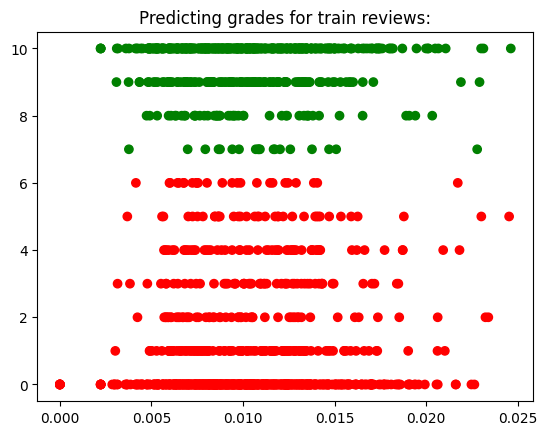

In [ ]:
# Plot the training data predictions:

colors = ['red' if val < 7 else 'green' for val in list(train_predict)]

pyplot.scatter( x = [ np.mean(x) for x in tfidf_arr_train ], y= list(train_predict), c=colors)
pyplot.title("Predicting grades for train reviews:")

# This graph looks similar to the graph for the first data fold. The means for the x-values
# seem to be less spread out, maybe due to the smaller vocabulary.

In [214]:
# TF-IDF matrix for the test data

corpus_test = [ x for x in list(user_dict_test2.keys()) ]

    # Print the TF-IDF matrix:
tfidf_matrix_test = vectorizer.transform(corpus_test)
tfidf_arr_test = tfidf_matrix_test.toarray()

print("TF-IDF array for test data fold 2:\n")
print(tfidf_arr_test)

TF-IDF array for test data fold 2:

[[0.         0.         0.         ... 0.06985248 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.13496606 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Predict grades for the reviews in the test data with random forest classifer:
test_predict = clf.predict(tfidf_arr_test)

    # Print how many times each grade shows up in the original testing data
    # and how many times each grade shows up in the test prediction data:
for x in range(0,11):
    print(f"Grade {x} appears {list(user_dict_test2.values()).count(x)} times in test data.")
    print(f"Grade {x} appears {list(test_predict).count(x)} times in prediction.")
    print()
    

# The trend for test prediction in the first fold continues for the second fold:

# The same prediction trend with grades 0 and 10 as found in the training data appeared
# again for the test data, on a much larger scale.

# Grade 0 was predicted to appear about half as much more than it does in the test data.
# Grade 10 doesn't perform as badly and is predicted about 100 less times than it actually appears in the test data.
# The model did not perform well in predicting values 1-9, for some of these not predicting any occurences at all.

# I tried running the model with more trees (up to 300), but it didn't improve much.
# The model performed worse with less trees (about 10 to 50).

Grade 0 appears 577 times in test data.
Grade 0 appears 1204 times in prediction.

Grade 1 appears 135 times in test data.
Grade 1 appears 4 times in prediction.

Grade 2 appears 78 times in test data.
Grade 2 appears 0 times in prediction.

Grade 3 appears 43 times in test data.
Grade 3 appears 1 times in prediction.

Grade 4 appears 49 times in test data.
Grade 4 appears 0 times in prediction.

Grade 5 appears 40 times in test data.
Grade 5 appears 1 times in prediction.

Grade 6 appears 18 times in test data.
Grade 6 appears 0 times in prediction.

Grade 7 appears 15 times in test data.
Grade 7 appears 0 times in prediction.

Grade 8 appears 44 times in test data.
Grade 8 appears 0 times in prediction.

Grade 9 appears 134 times in test data.
Grade 9 appears 3 times in prediction.

Grade 10 appears 366 times in test data.
Grade 10 appears 286 times in prediction.



Text(0.5, 1.0, 'Predicting grades for test reviews:')

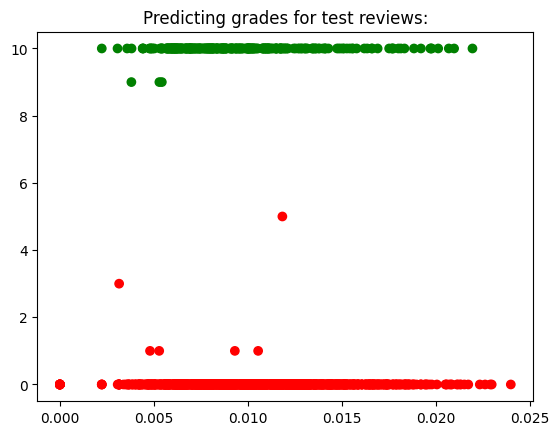

In [ ]:
# Plot the test predictions:

colors = ['red' if val < 7 else 'green' for val in list(test_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_test], y=list(test_predict), c=colors)
pyplot.title("Predicting grades for test reviews:")

# The plot for the second fold of test data is quite similar to the first fold's plot.

In [218]:
# Training the model on the training data for the second fold and corresponding binary y-values:
    
    # One-hot encoded y-value data:
all_grades = [0 if x < 7 else 1 for x in list(user_dict_train2.values())]
clf = RandomForestClassifier(max_depth=70)

    # Training the model:
clf.fit(tfidf_arr_train, all_grades)
train_predict = clf.predict(tfidf_arr_train)

In [219]:
# Comparing the training data and prediction based on the training data:

negative_train = [i for i in list(user_dict_train2.values()) if i < 7 ]
positive_train = [i for i in list(user_dict_train2.values()) if i > 7 ]

negative_predict_tr = [i for i in train_predict if i < 1 ]
positive_predict_tr = [i for i in train_predict if i > 0 ]


    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:

print(f"Negative reviews appear {len(negative_train)} times in train data.")
print(f"Positive reviews appear {len(positive_train)} times in train data.")
print()
print(f"Negative reviews appear {len(negative_predict_tr)} times in prediction.")
print(f"Positive reviews appear {len(positive_predict_tr)} times in prediction.")
    

# More or less, the frequency of grades predicted are very accurate and close
# to the training data.

Negative reviews appear 929 times in train data.
Positive reviews appear 552 times in train data.

Negative reviews appear 935 times in prediction.
Positive reviews appear 565 times in prediction.


Text(0.5, 1.0, 'Predicting train reviews as negative or positive:')

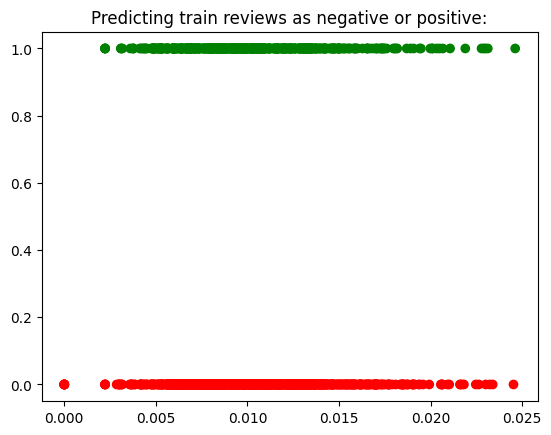

In [220]:
# Plot the new train predictions:

colors = ['red' if val < 1 else 'green' for val in list(train_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_train], y=list(train_predict), c=colors)
pyplot.title("Predicting train reviews as negative or positive:")

In [ ]:
# Predict based on test data:
test_predict = clf.predict(tfidf_arr_test)

# Comparing the training data and prediction based on the training data:

negative_test = [i for i in list(user_dict_test2.values()) if i < 7 ]
positive_test = [i for i in list(user_dict_test2.values()) if i > 7 ]

negative_predict_te = [i for i in test_predict if i < 1 ]
positive_predict_te = [i for i in test_predict if i > 0 ]


    # Print how many times each grade shows up in the training data
    # and how many times each grade shows up in the training prediction data:

print(f"Negative reviews appear {len(negative_test)} times in test data.")
print(f"Positive reviews appear {len(positive_test)} times in test data.")
print()
print(f"Negative reviews appear {len(negative_predict_te)} times in prediction.")
print(f"Positive reviews appear {len(positive_predict_te)} times in prediction.")
    
# Findings again are similar to the first fold as they are in this second fold:

# When categorized purely as positive or negative, the testing data performs alright, but there is quite
# a skew twoards the negative reviews than the positive reviews as comapred with the original testing data.

# The positive reviews predicted have about a loss of 200 reviews, whereas the negative reviews predicted
# gained about 200 reviews.

Negative reviews appear 940 times in test data.
Positive reviews appear 544 times in test data.

Negative reviews appear 1276 times in prediction.
Positive reviews appear 223 times in prediction.


Text(0.5, 1.0, 'Predicting test reviews as negative or positive:')

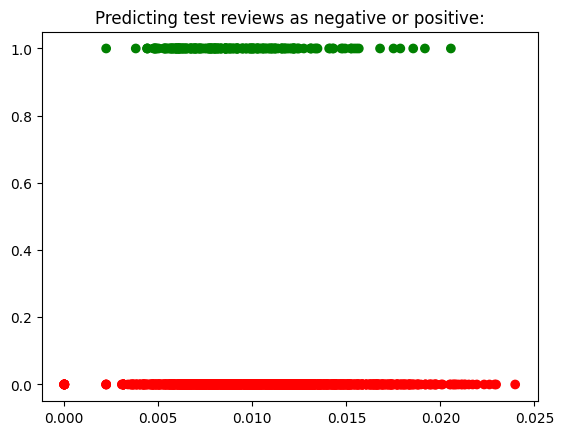

In [222]:
# Plot the test predictions:

colors = ['red' if val < 1 else 'green' for val in list(test_predict)]
pyplot.scatter(x=[np.mean(x) for x in tfidf_arr_test], y=list(test_predict), c=colors)
pyplot.title("Predicting test reviews as negative or positive:")

In [ ]:
# In both folds, the random forest classifier algorithms
# produce very similar results, showing patterns are found consistently
# across the entire dataset of reviews for Animal Crossing New Horizons.

# The thing that was most different were the clusters for positive reviews in each
# fold.  Finding which words define a positive vs. negative cluster may prove
# to be difficult for the second fold than the first, as the two clusters were more similar
# in the second fold.